In [8]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/9/29 16:01
# @Author  : Wang Yujia
# @File    : basicinfo_outcomes.ipynb
# @Description : 关于outcomes.tsv数据集的一些basic信息

[TOC]
# 0. what for
1. 旨在输出一些关于outcomes数据集的一些basic信息
2. 部分代码来自`BasicInfo_outcomes.py`这个py现在基本不用了

# 1. Preparations
## 1.1 全局设置

In [ ]:
# data path
outcomes_orignal_path = "../data/outcomes.tsv"
traces_original_path = "../data/traces.tsv"
# outcomes和traces共有的auction_id: `common_auction_id`
common_auction_id_path = "../data/common_auction_id.csv"

# 最终GT model需要的features（不包括np），其中`product_id` is not necessary
features_GT = ['auction_id','product_id','bidincrement','bidfee','retail']
# 衡量一场auction是否unique的标志
unique_setting = ['product_id', 'bidincrement', 'bidfee','retail']
# fixed-auction flag
flg_fixed = ['flg_fixedprice']

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1.2 读取data

In [2]:
outcomes = pd.read_csv(outcomes_orignal_path, sep='\t')
traces = pd.read_csv(traces_original_path, sep='\t')
common_auction_id = pd.read_csv(common_auction_id_path, encoding="utf-8").auction_id

# 2. Info about outcomes.tsv
## 2.1 how many auctions are recorded

In [11]:
auction_id_unique = outcomes['auction_id'].unique()
n_auction_outcomes = auction_id_unique.shape[0]
print("outcomes.tsv记录了*{}*场auction".format(n_auction_outcomes))

outcomes.tsv记录了*121419*场auction
outcomes.tsv记录了*121419*场auction


## 2.2 how many asc/ fixed-price auctions here?
1. recall that traces.tsv have no fixed-price auctions

In [27]:
outcomes_fixed = outcomes[np.array(outcomes[flg_fixed] == 1)]   # 记得转化成array，否则容易因为index不对应产生NaN值
print("outcomes.tsv 中一共有 *{}* 场auctions 是 fixed-price auction.".format(outcomes_fixed.shape[0]))

outcomes_asc = outcomes[np.array(outcomes[flg_fixed] == 0)]
print("outcomes.tsv 中一共有 *{}* 场auctions 是 ascending-price auction.".format(outcomes_asc.shape[0]))

assert(outcomes_fixed.shape[0]+outcomes_asc.shape[0] == outcomes.shape[0],"ascending-price + fixed-price总数量不正确")

outcomes.tsv 中一共有 *2203* 场auctions 是 fixed-price auction.
outcomes.tsv 中一共有 *119216* 场auctions 是 ascending-price auction.


## 2.3 Do all asc/ fixed-price have 'finalprice' == 'price'
1. > finalprice: The price charged to the winner in dollars
   > price: The price the auction reached, in dollars

2. 因此`finalprice`是最后的要价，`price`是单纯拍卖reach到的价格。
3. ascending-price的'finalprice'和'price'是不是都相同的: *No*
    - 有相同的也有不同的，大多数相同
4. fixed-price的'finalprice'和'price'是不是都相同的: *Only one is not the same*
    - 按道理说，定价拍卖的winner不会支付 'price'这个价格，他们付的会是'finalprice'吗？ *[see 2.4]*
    - 可以清洗掉这个吧

In [34]:
print("There is totally *{}* ascending-price auctions whose 'finalprice' == 'price'".format(sum(outcomes_asc['finalprice'] == outcomes_asc['price'])))
print("There is totally *{}* fixed-price auctions whose 'finalprice' == 'price'".format(sum(outcomes_fixed['finalprice'] == outcomes_fixed['price'])))

There is totally *114660* ascending-price auctions whose 'finalprice' == 'price'
There is totally *1* fixed-price auctions whose 'finalprice' == 'price'


## 2.4 Do all fixed-price auctions have 'finalprice' < 'price'
1. 既然'finalprice' ！= 'price'，而且定价拍卖的bidder不会pay 'price'这个价格，'finalprice' 和'price'有什么关系吗
2. 下图可以看出'finalprice'<'price', mostly
3. 容易设想，既然finalprice表示网站charge的价格，同时在fixed-price下，winner should pay 一个网站给定的价格，'finalprice'应该就是the price winner pay

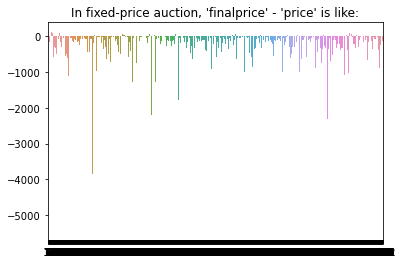

In [43]:
sns.barplot(x=np.arange(0,outcomes_fixed.shape[0]),y=(outcomes_fixed['finalprice'] - outcomes_fixed['price']))
plt.title("In fixed-price auction, 'finalprice' - 'price' is like:")
plt.show()

## 2.5 Do all fixed-price auctions have 'bid_increment' == 0
1. fixed-price的auction的bid_increment是不是全都是0: *None*
2. **Attention:**
    - 虽然`bid_increment`不等于0，但是GT model中通过对bidder的建模，bidders并不在意这个，只关注`v`和`p`的关系
    - 因此在GT中其实需要collect相关信息，它可以作为NN的input

In [19]:
print("There is totally *{}* fixed-price auctions whose 'bid_increment' is zero".format(sum(outcomes_fixed['bidincrement'] == 0)))

There is totally *0* fixed-price auctions whose 'bid_increment' is zero


## 2.6 For all auctions, are there always 'bidfee' < 'retail'?


In [13]:
outcomes_greater_bidfee = outcomes[(outcomes['bidfee']*0.01)>=outcomes['retail']]
print("There is totally *{}* auctions whose 'bidfee' >= 'retail'".format(outcomes_greater_bidfee.shape[0]))
print("And we could drop them in pre-preprocess")

There is totally *32* auctions whose 'bidfee' >= 'retail'
And we could drop them in pre-preprocess
